## 深層学習の実習

### 訓練データとテストデータそれぞれの画像ファイルを読み込む

#### `image_dataset_from_directory()` で読み込む

In [1]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横224pxにリサイズする）
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "nagaoka_gis/train",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "nagaoka_gis/test",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 20 files belonging to 2 classes.
Found 6 files belonging to 2 classes.


#### データを確認する

In [2]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

2025-08-12 16:14:30.202124: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[[ 14.698979 ,  33.69898  ,  13.698979 ],
          [ 31.691324 ,  50.691326 ,  30.691324 ],
          [ 37.900513 ,  62.471943 ,  34.75766  ],
          ...,
          [  9.188563 ,  27.257444 ,  27.22166  ],
          [ 13.627563 ,  25.913452 ,  32.627563 ],
          [ 10.951526 ,  25.380116 ,  29.237232 ]],
 
         [[ 29.841835 ,  48.841835 ,  28.841835 ],
          [ 22.772959 ,  41.772957 ,  21.772959 ],
          [ 46.21173  ,  70.78316  ,  43.068874 ],
          ...,
          [ 23.051016 ,  42.479607 ,  46.612164 ],
          [ 13.767905 ,  26.053793 ,  35.2118   ],
          [ 13.826535 ,  28.255123 ,  33.57141  ]],
 
         [[ 41.966835 ,  60.966835 ,  40.966835 ],
          [ 44.614796 ,  63.614796 ,  43.614796 ],
          [ 63.673473 ,  88.2449   ,  60.530617 ],
          ...,
          [ 19.538597 ,  42.079426 ,  36.431385 ],
          [ 10.548287 ,  21.834175 ,  34.405464 ],
          [  7.77805  ,  21.920933 ,  30.34946  ]],
 
         ...,
 
         [[ 

In [3]:
# 分類名（no／yes）をリストとして格納する
class_names = train_dataset.class_names
class_names

['no', 'yes']

2025-08-12 16:17:48.174610: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


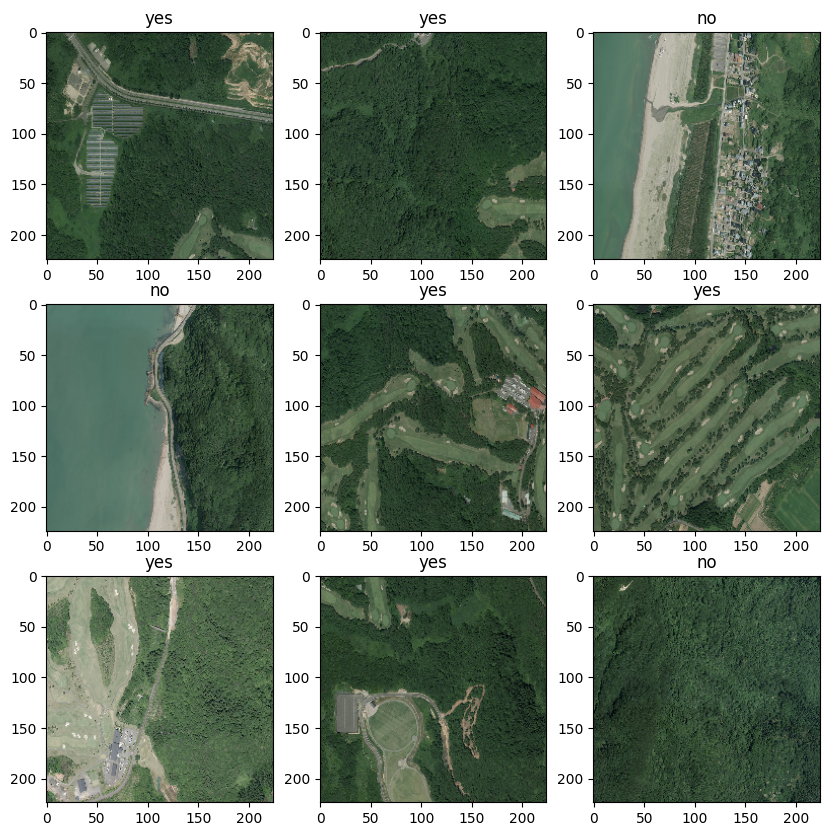

In [4]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### データの水増しを行なう

In [5]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

In [6]:
# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

In [7]:
# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

In [8]:
# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

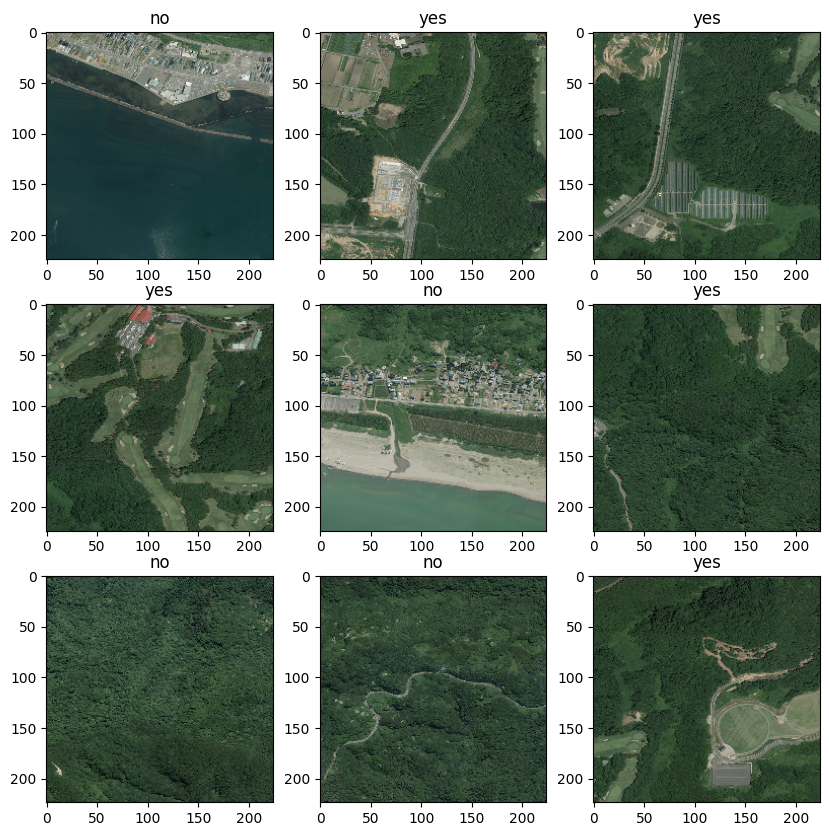

In [9]:
# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### モデルを作って学習する

#### MobileNetV2の学習済みモデルを読み込む

In [10]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(224, 224, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    input_tensor=l_layer,
    include_top=False,
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### 出力層を作成する

In [11]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

#### モデルを完成させる

In [12]:
# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

In [13]:
# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [14]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.6583 - loss: 0.6261
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8750 - loss: 0.4068
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9333 - loss: 0.2790
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9667 - loss: 0.2012
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9750 - loss: 0.1536
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9917 - loss: 0.1194
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9917 - loss: 0.0975
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.0821
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0703
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 0.0612
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 0.0537
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 0.048

In [15]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


In [16]:
# 分類した結果を確認する
pred_data

array([[0.18464695],
       [0.17473592],
       [0.21488601],
       [0.99442816],
       [0.6654568 ],
       [0.9855923 ]], dtype=float32)

In [17]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step - accuracy: 1.0000 - loss: 0.1776


[0.1775822788476944, 1.0]